<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/ATAC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of ATAC-seq data and combined ATAC-seq/RNA-seq of Etv2 induced MEF reprogramming and ES/EB differentiation
by Wuming Gong



In [84]:
start_time0 <- Sys.time()

## Install R packages

In [85]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

In [86]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

In [87]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [88]:
required_packages <- c(
  'devtools', 'circlize', 'dplyr', 'gplots', 'plyr',
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel', 
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 
  'gsl', 'DirichletMultinomial', 'chromVAR', 'motifmatchr', 'PWMEnrich',
  'ComplexHeatmap',
  'DESeq2',
  'VennDiagram', 'ggwordcloud'
)

In [89]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [90]:
devtools::install_github("GreenleafLab/chromVARmotifs")

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



In [91]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(ComplexHeatmap)
register(MulticoreParam(2)) 
library(plyr)
library(dplyr)
library(DESeq2)
library(VennDiagram)
library(ggwordcloud) 

## Read replicate-level ATAC-seq data

In [92]:
# Read the ATAC-seq read counts data for each sample and count the motifs at each interval
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/ATAC_peaks_Etv2_reprogramming.rds')))
se <- se[, colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos', 'MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')]
se <- se[rowSums(assays(se)$counts > 0) >= 2]
is_MEF <- colData(se)$group %in% c('MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
is_EB <- colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
se

class: RangedSummarizedExperiment 
dim: 168305 16 
metadata(0):
assays(1): counts
rownames(168305): chr1 chr1 ... chrY chrY
rowData names(0):
colnames: NULL
colData names(9): study_accession run ... tissue bw_file

In [93]:
colData(se)$group %>% table()

.
        EB_Dox_D25 EB_Dox_D25_Flk1pos       EB_NoDox_D25         MEF_Dox_D1 
                 2                  2                  2                  2 
        MEF_Dox_D2         MEF_Dox_D7 MEF_Dox_D7_Flk1pos          MEF_NoDox 
                 2                  2                  2                  2 

## Read scRNA-seq of MEF reprogramming

In [94]:
sc_file <- 'https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds'
command <- sprintf('wget -x -c -nH %s', sc_file)
command %>% system()

In [95]:
se_sc <- gsub('https://s3.msi.umn.edu/', './', sc_file) %>% readRDS()
table(colData(se_sc)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Find the DE genes between MEF D7 Flk1+ cells and undifferentiated MEF

In [96]:
X <- assays(se_sc)$scaled_counts
j_MEF_NoDox <- colData(se_sc)$group %in% 'MEF_NoDox'
j_MEF_Dox_D7_Flk1pos <- colData(se_sc)$group %in% c('MEF_Dox_D7b')
pvalues <- mclapply(
  1:nrow(X), 
  function(i) wilcox.test(X[i, j_MEF_Dox_D7_Flk1pos], X[i, j_MEF_NoDox])$p.value,
  mc.cores = 2
) %>% unlist()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



## Read bulk RNA-seq of EB differentiation

In [97]:
se_bulk <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))

## Find  DE genes between no dox and Flk1+ cells post induction

In [98]:
se_bulk <- DESeqDataSet(se_bulk, design = ~ group)
se_bulk <- estimateSizeFactors(se_bulk)
se_bulk <- DESeq(se_bulk)
assays(se_bulk)$normalized_counts <- log2(counts(se_bulk, normalized = TRUE) + 1)
res <- results(se_bulk, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_bulk, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Merge the scRNA-seq and bulk RNA-seq by gene symbols.


In [99]:
d_rna_merge <- merge(
  data.frame(
    symbol = rownames(res), 
    EB_log2FoldChange = res$log2FoldChange, 
    EB_pvalue = res$pvalue
  ),
  data.frame(
    symbol = rowData(se_sc)$name, 
    MEF_log2FoldChange = rowMeans(X[, j_MEF_Dox_D7_Flk1pos]) - rowMeans(X[, j_MEF_NoDox]), 
    MEF_pvalue = pvalues
  ),
  by.x = 'symbol',
  by.y = 'symbol'
) %>%
  filter(!is.na(EB_pvalue) & !is.na(MEF_pvalue)) %>%
  filter(!duplicated(symbol))
rownames(d_rna_merge) <- d_rna_merge$symbol
d_rna_merge %>% filter(symbol %in% c('Etv2', 'Kdr', 'Emcn', 'Cdh5', 'Runx1'))

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cdh5,Cdh5,7.534863,1.315189e-43,1.5647330,0.000000e+00
Emcn,Emcn,5.908320,6.634402e-03,1.4578199,0.000000e+00
Etv2,Etv2,5.462880,0.000000e+00,1.1166636,3.666651e-272
Kdr,Kdr,7.093824,0.000000e+00,1.7277936,0.000000e+00
Runx1,Runx1,1.891086,1.139845e-11,-0.3865211,1.138801e-25


## chromVAR analysis of combined ATAC-seq data


In [100]:
data("mouse_pwms_v2") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(mouse_pwms_v2, se, genome = 'mm10')

### Looking for significantly changed motifs in EB

In [101]:
valid <- rowSums(assays(se[, is_EB])$counts > 0) >= 2
dev_EB <- computeDeviations(object = se[valid, is_EB], annotations = motif_ix[valid, ])
v_EB <- computeVariability(dev_EB)

### Looking for significantly changed motifs in MEF

In [102]:
valid <- rowSums(assays(se[, is_MEF])$counts > 0) >= 2
dev_MEF <- computeDeviations(object = se[valid, is_MEF], annotations = motif_ix[valid, ])
v_MEF <- computeVariability(dev_MEF)

number of significantly changed motifs in EB: 715


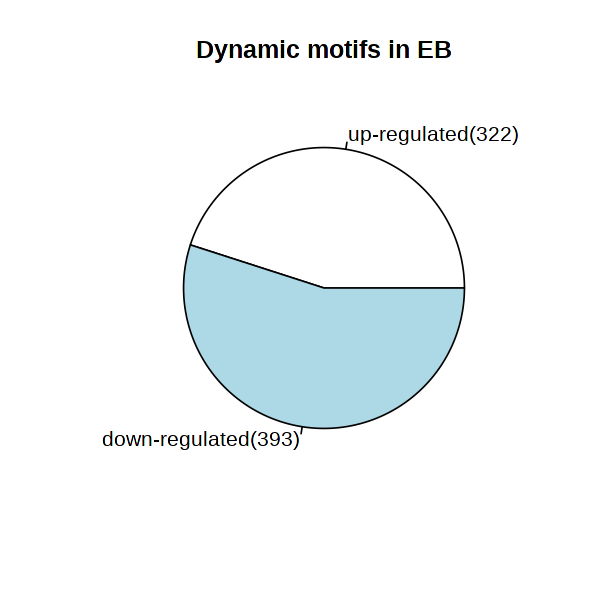

In [103]:
d_EB_Dox_D25_Flk1pos <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_Dox_D25_Flk1pos')])
d_EB_NoDox_D25 <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_NoDox_D25')])
n_EB_up <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25)
n_EB_down <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25)
cat(sprintf('number of significantly changed motifs in EB: %d\n', sum(v_EB$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_EB_up, n_EB_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_EB_up, n_EB_down)),
  main = "Dynamic motifs in EB"
)

number of significantly changed motifs in MEF: 743


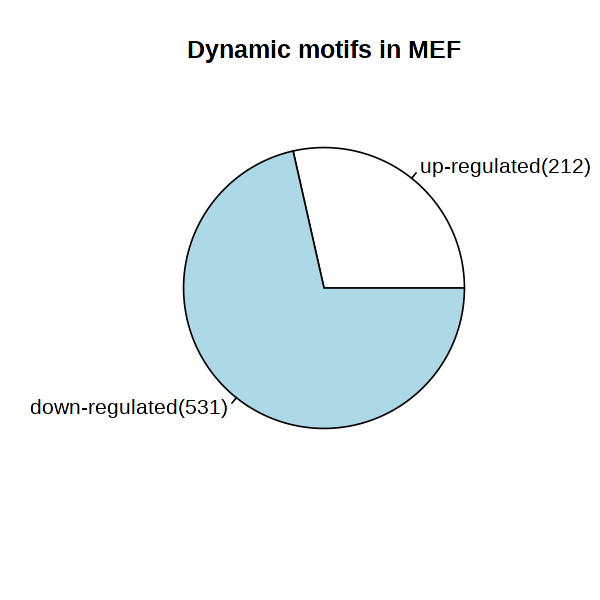

In [104]:
d_MEF_Dox_D7_Flk1pos <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_Dox_D7_Flk1pos')])
d_MEF_NoDox <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_NoDox')])
n_MEF_up <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox)
n_MEF_down <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox)
cat(sprintf('number of significantly changed motifs in MEF: %d\n', sum(v_MEF$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_MEF_up, n_MEF_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_MEF_up, n_MEF_down)),
  main = "Dynamic motifs in MEF"
)

(polygon[GRID.polygon.11565], polygon[GRID.polygon.11566], polygon[GRID.polygon.11567], polygon[GRID.polygon.11568], text[GRID.text.11569], text[GRID.text.11570], text[GRID.text.11571], text[GRID.text.11572], text[GRID.text.11573]) 

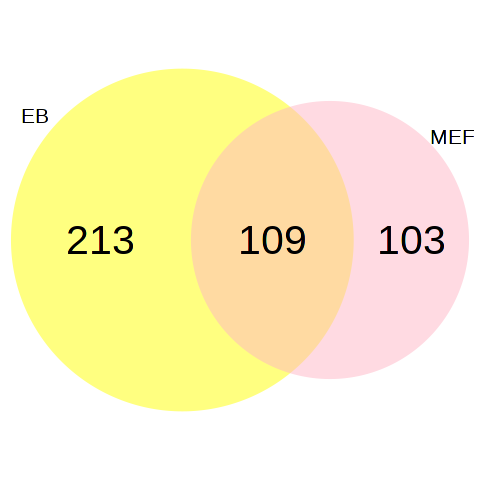

In [105]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)

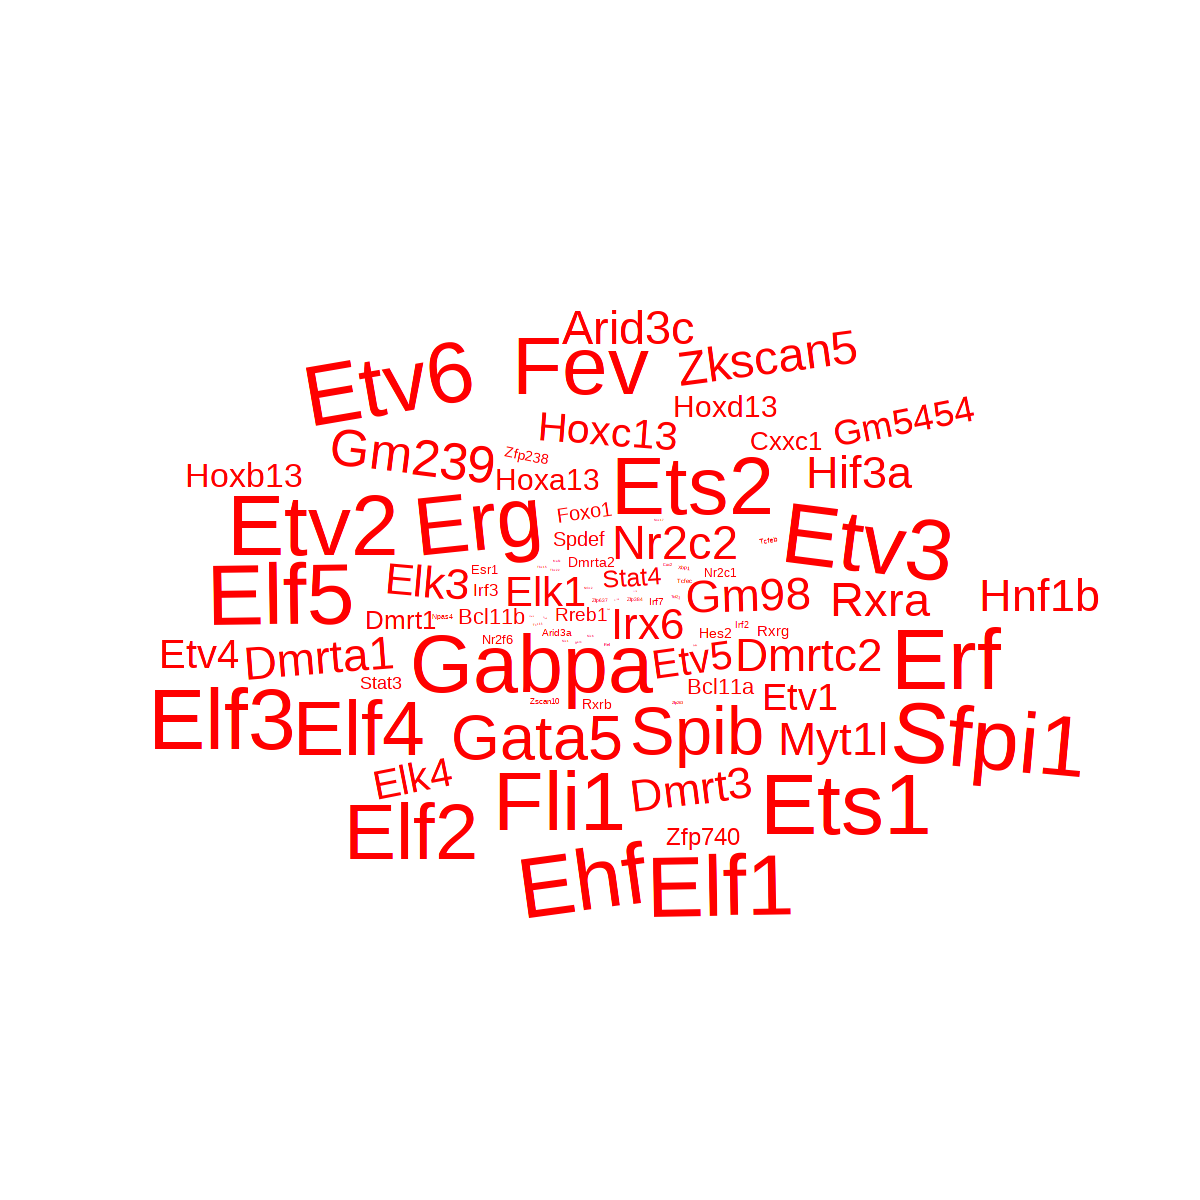

In [106]:
is_overlap <- v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox
df <- data.frame(
  word = v_EB$name[is_overlap],
  freq = -log10(v_EB$p_value_adj[is_overlap] + 1e-200) + -log10(v_MEF$p_value_adj[is_overlap] + 1e-200)
) %>%
  filter(!grepl('^ENSMU', word)) %>%
  filter(!grepl('^LINE', word))

options(repr.plot.width = 10, repr.plot.height = 10)
ggwordcloud2(df, size = 1, color = 'red')

(polygon[GRID.polygon.12133], polygon[GRID.polygon.12134], polygon[GRID.polygon.12135], polygon[GRID.polygon.12136], text[GRID.text.12137], text[GRID.text.12138], text[GRID.text.12139], text[GRID.text.12140], text[GRID.text.12141]) 

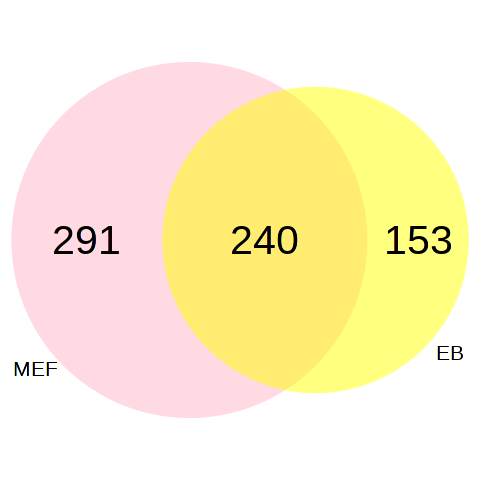

In [107]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)

Some words could not fit on page. They have been removed.



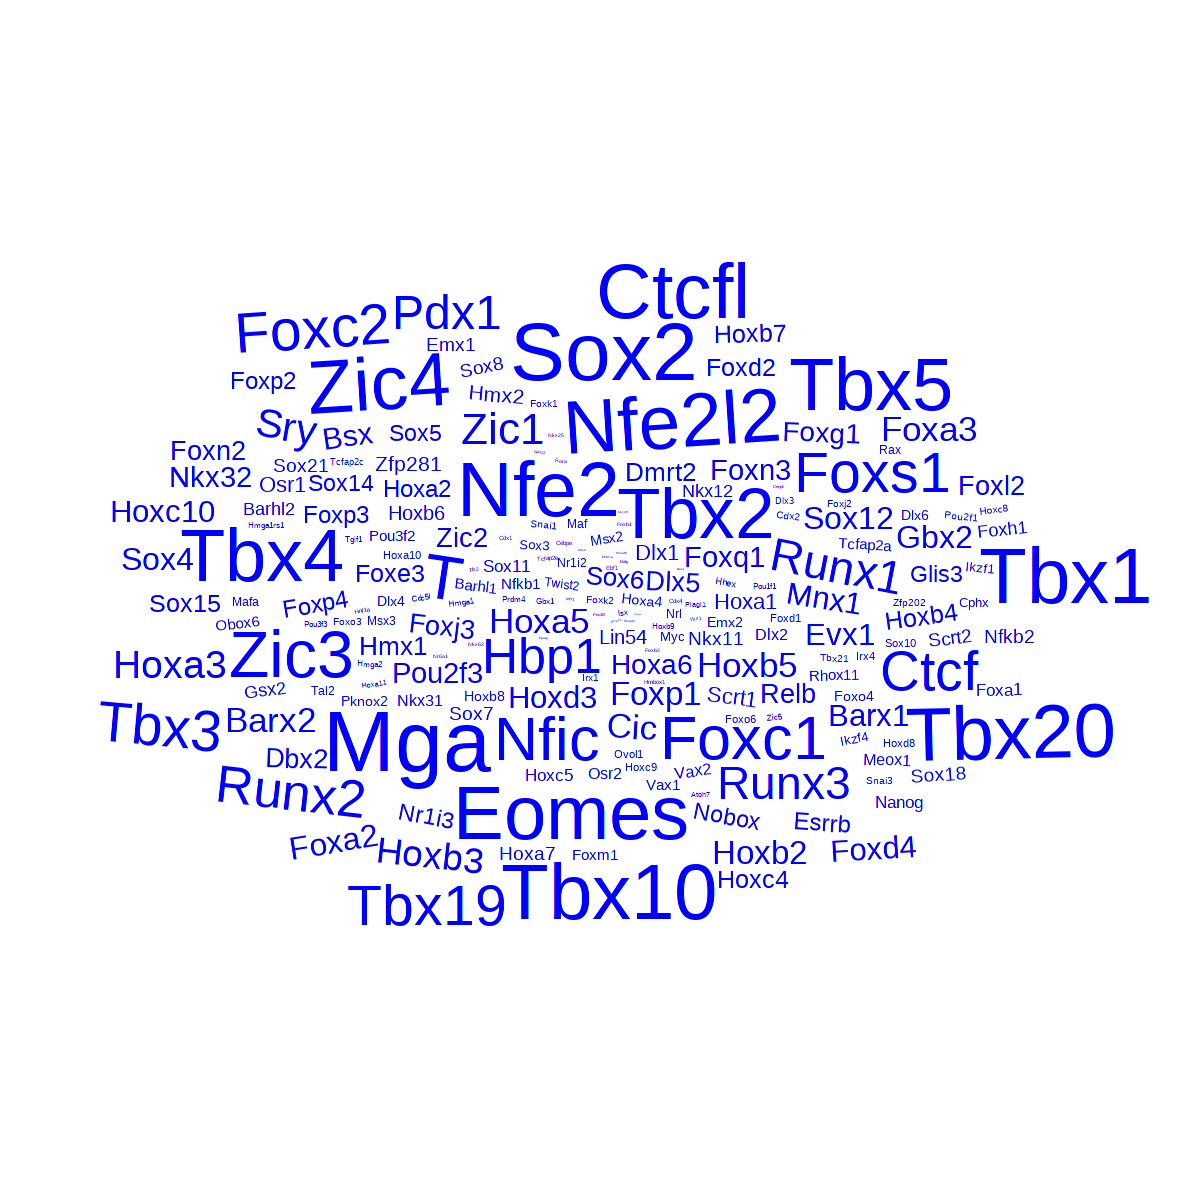

In [108]:
is_overlap <- v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox
df <- data.frame(
  word = v_EB$name[is_overlap],
  freq = -log10(v_EB$p_value_adj[is_overlap] + 1e-200) + -log10(v_MEF$p_value_adj[is_overlap] + 1e-200)
) %>%
  filter(!grepl('^ENSMU', word)) %>%
  filter(!grepl('^LINE', word))

options(repr.plot.width = 10, repr.plot.height = 10)
ggwordcloud2(df, size = 1, color = 'blue')

### PCA

In [109]:
data("homer_pwms") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(homer_pwms, se, genome = 'mm10')
dev <- computeDeviations(object = se, annotations = motif_ix)
v <- computeVariability(dev)
v[grep('Etv2', v$name), ]

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967),Etv2(ETS),22.1443,13.39608,27.81439,0,0


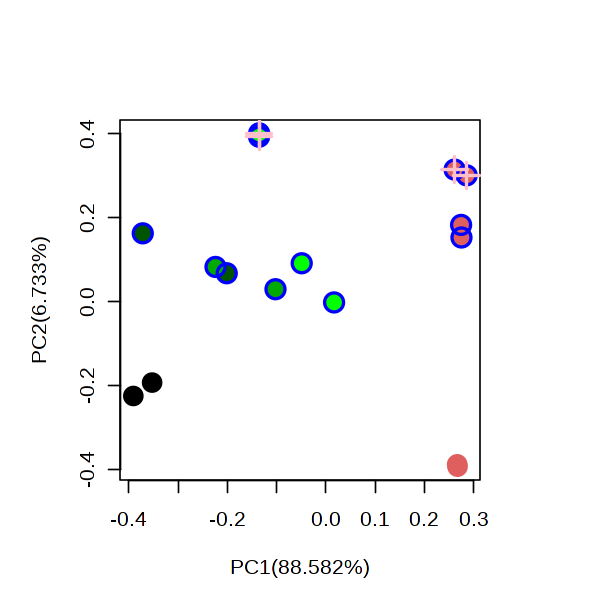

In [110]:
# Plot PCA of the motif deviations 
m <- v$p_value_adj < 0.05
s <- prcomp(assays(dev)$z[m, ])
eigs <- s$sdev^2

colData(se)$cell <- gsub('(.+?)_.+', '\\1', colData(se)$group)
colData(se)$dox <- rep("Dox", ncol(se))
colData(se)$dox[grep('NoDox', colData(se)$group)] <- 'NoDox'
MEF_cols <- colorpanel(4, low = 'black', high = 'green')
EB_cols <- colorpanel(3, low = 'gray', high = 'red')
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D0' = EB_cols[1],
  'EB_NoDox_D25' = EB_cols[2],
  'EB_NoDox_D3' = EB_cols[3],
  'EB_NoDox_D3_Flk1pos' = EB_cols[3],

  'EB_Dox_D0' = EB_cols[1],
  'EB_Dox_D25' = EB_cols[2],
  'EB_Dox_D25_Flk1pos' = EB_cols[2],
  'EB_Dox_D3' = EB_cols[3],
  'EB_Dox_D3_Flk1pos' = EB_cols[3]
)
is_flk1pos <- grepl('Flk1pos', colData(se)$group)
is_dox <- grepl('_Dox_', colData(se)$group)
pc_x <- 1; pc_y <- 2

par(mar = c(5, 5, 5 , 5))
options(repr.plot.width=5, repr.plot.height=5)
plot(s$rotation[, pc_x], s$rotation[, pc_y], pch = 21, bg = group2col[colData(se)$group], col = group2col[colData(se)$group], cex = 2, xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100))
points(s$rotation[is_dox, pc_x], s$rotation[is_dox, pc_y], pch = 21, col = 'blue', cex = 2, lwd = 2)
points(s$rotation[is_flk1pos, pc_x], s$rotation[is_flk1pos, pc_y], pch = 3, col = 'pink', cex = 2, lwd = 2)

## Prepare data frame that includes EB/MEF and RNA-seq/motif information


In [111]:
head(d_rna_merge)

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0610005C13Rik,0610005C13Rik,2.2176660,0.003103568,0.01211949,3.800684e-02
0610009B22Rik,0610009B22Rik,0.1199313,0.512962604,0.65405450,3.036480e-11
0610009O20Rik,0610009O20Rik,0.1195349,0.294842818,-0.15085049,1.388946e-11
0610010F05Rik,0610010F05Rik,0.1665818,0.290078194,-0.61464126,7.809837e-55
0610010K14Rik,0610010K14Rik,-0.4331971,0.001113826,-0.16765820,1.543557e-17
0610012G03Rik,0610012G03Rik,-0.4166797,0.027842812,-0.14158193,4.620563e-06


In [112]:
d_motif <- data.frame(
  symbol = v_MEF$name,
  MEF_motif_diff = d_MEF_Dox_D7_Flk1pos - d_MEF_NoDox,
  MEF_motif_pvalue = v_MEF$p_value_adj,
  EB_motif_diff = d_EB_Dox_D25_Flk1pos - d_EB_NoDox_D25,
  EB_motif_pvalue = v_EB$p_value_adj
)
head(d_motif)

,symbol,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000021359_LINE1_Tcfap2a_D_N1,Tcfap2a,-0.04988193,1.793453e-31,-0.0165079887,1.416437e-10
ENSMUSG00000025927_LINE5_Tcfap2b_D,Tcfap2b,-0.02949791,4.092457e-04,-0.0033354868,2.892251e-02
ENSMUSG00000028640_LINE6_Tcfap2c_D,Tcfap2c,-0.04198592,9.099680e-21,-0.0005698707,1.349064e-03
ENSMUSG00000042477_LINE7_Tcfap2e_D,Tcfap2e,-0.03697916,6.147617e-04,-0.0273744913,1.891768e-13
ENSMUSG00000042596_LINE8_Tcfap2d_I,Tcfap2d,0.03576853,5.070660e-66,-0.0222497018,5.379054e-66
ENSMUSG00000004661_LINE10_Arid3b_D,Arid3b,-0.02099254,7.490437e-04,-0.0084808834,4.206816e-01


In [113]:
d_merge <- merge(d_rna_merge, d_motif, by.x = 'symbol', by.y = 'symbol')
d_merge %>% filter(symbol == 'Etv2')

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Etv2,5.46288,0,1.116664,3.666651e-272,0.372728,0,0.3168329,0


## Commonly up-regulated TFs in EB


(polygon[GRID.polygon.13397], polygon[GRID.polygon.13398], polygon[GRID.polygon.13399], polygon[GRID.polygon.13400], text[GRID.text.13401], text[GRID.text.13402], text[GRID.text.13403], text[GRID.text.13404], text[GRID.text.13405]) 

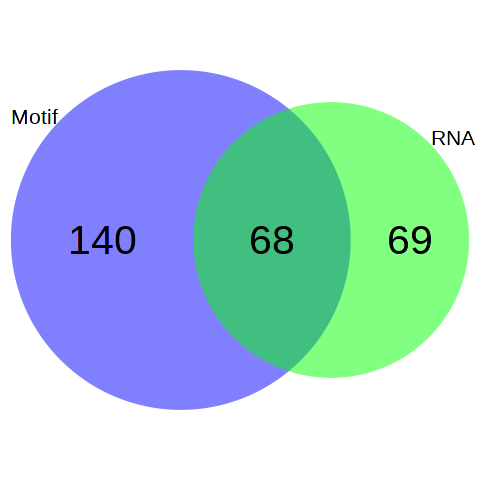

In [114]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)

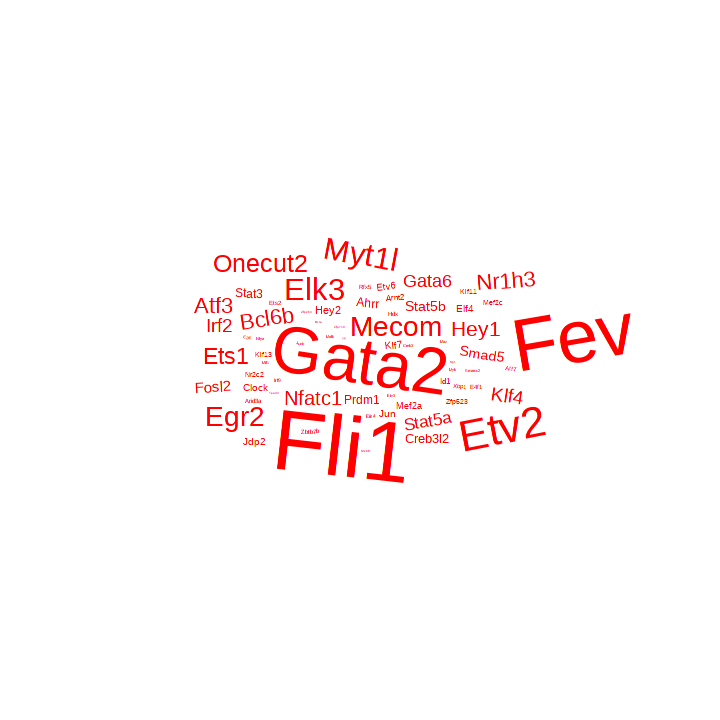

In [115]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff > 0 & EB_pvalue < 0.05 & EB_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'red')

## Commonly up-regulated TFs in MEF

(polygon[GRID.polygon.13827], polygon[GRID.polygon.13828], polygon[GRID.polygon.13829], polygon[GRID.polygon.13830], text[GRID.text.13831], text[GRID.text.13832], text[GRID.text.13833], text[GRID.text.13834], text[GRID.text.13835]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ar,1.91818995,2.339774e-07,0.30181526,1.305945e-02,0.0892438387,1.214839e-14,0.009349840,1.890480e-01
Elk1,0.13196628,2.763154e-01,0.06724421,1.974680e-03,0.0050678985,6.628464e-116,0.074633775,2.652840e-79
Elk3,3.89322129,7.293291e-176,0.64554017,2.629787e-28,0.0055551055,7.374991e-130,0.074024889,4.396243e-76
Erf,0.17156413,1.042432e-01,0.00561777,3.136392e-09,0.2427998490,0.000000e+00,0.231421559,0.000000e+00
Etv2,5.46287962,0.000000e+00,1.11666357,3.666651e-272,0.3727279639,0.000000e+00,0.316832862,0.000000e+00
Fev,9.34336647,1.459927e-10,0.07294158,3.652266e-07,0.0984225540,1.305276e-180,0.144957978,1.459549e-276
Fli1,10.82302145,5.097621e-83,0.32156639,8.789963e-03,0.1050765225,1.083476e-188,0.150990096,0.000000e+00
Foxo1,-0.04173841,7.448086e-01,0.74523012,5.050680e-63,0.0468574940,2.492130e-21,0.060942967,1.578961e-70
Hic1,-1.93070041,7.558882e-02,0.35028880,8.806095e-06,0.0198855190,3.331036e-24,-0.062091997,4.521419e-66


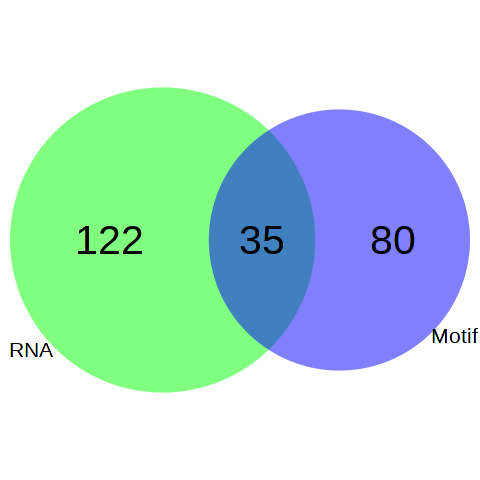

In [116]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)

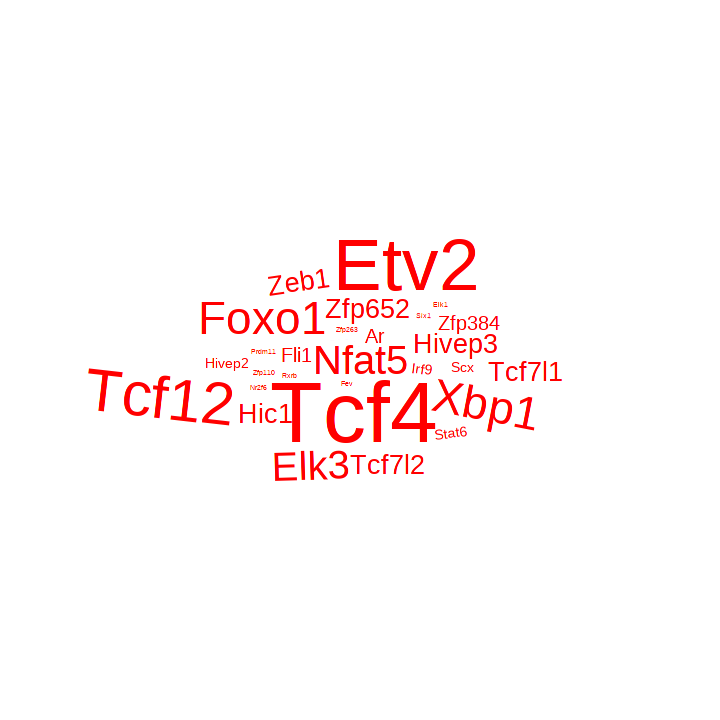

In [117]:
g <- d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'red')


## Commonly down-regulated TFs in EB

(polygon[GRID.polygon.14073], polygon[GRID.polygon.14074], polygon[GRID.polygon.14075], polygon[GRID.polygon.14076], text[GRID.text.14077], text[GRID.text.14078], text[GRID.text.14079], text[GRID.text.14080], text[GRID.text.14081]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arid5b,-0.9613975,1.627464e-04,-0.433185218,2.184590e-39,-0.014156787,8.806025e-01,-0.116352001,2.167063e-16
Dbp,-1.5129366,3.682397e-07,0.369605676,4.342885e-23,-0.084058809,3.960196e-01,-0.021754034,9.058938e-04
Dlx2,-3.7050465,3.185797e-02,-0.371028775,7.234171e-19,-0.090263115,1.816812e-20,-0.106455126,3.132693e-24
Dnajc21,-1.3965521,1.450235e-25,-0.459882998,9.338145e-44,0.020233363,1.680695e-28,-0.012720544,7.443155e-65
En1,-4.2319297,4.529304e-05,0.061860133,4.596258e-03,0.030839652,9.854972e-01,-0.044512433,2.659796e-27
Eomes,-3.4036983,4.660843e-188,-0.175532802,9.318090e-05,-0.033098504,6.950582e-09,-0.149626642,0.000000e+00
Foxa2,-5.3567505,1.593324e-44,-0.033782989,9.470553e-02,-0.058078508,5.012115e-36,-0.088930670,4.968969e-53
Foxc1,-1.0402297,2.641499e-02,0.169467793,1.646391e-03,-0.095959891,6.077549e-160,-0.029614456,4.284595e-07
Foxk2,-0.3424798,2.793676e-04,-0.334041905,9.428383e-32,-0.053568481,1.096769e-23,-0.021622907,1.360335e-03


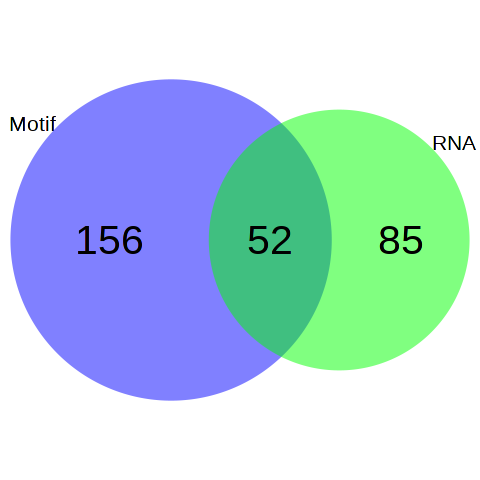

In [118]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff < 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)

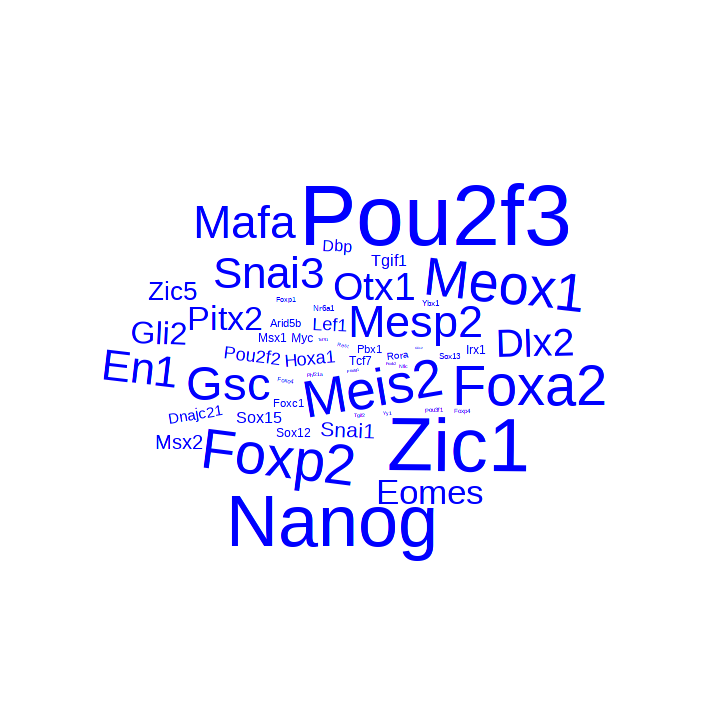

In [119]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'blue')


## Commonly down-regulated TFs in MEF

(polygon[GRID.polygon.14407], polygon[GRID.polygon.14408], polygon[GRID.polygon.14409], polygon[GRID.polygon.14410], text[GRID.text.14411], text[GRID.text.14412], text[GRID.text.14413], text[GRID.text.14414], text[GRID.text.14415]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ahctf1,-0.37710523,2.513277e-03,-0.58092264,1.754755e-54,-0.030842438,3.310858e-21,0.024422954,2.562202e-11
Arid3b,-1.45908668,7.382937e-55,-0.12304407,6.536180e-05,-0.020992543,7.490437e-04,-0.008480883,4.206816e-01
Arid5a,-0.55322854,2.777540e-01,-0.06833474,3.157943e-04,-0.041490078,1.813172e-08,-0.005000335,7.645163e-01
Arnt2,0.93608919,3.395964e-13,-0.05917111,1.071388e-04,-0.062426156,1.661218e-43,0.011083026,1.155027e-02
Cdc5l,-0.03067072,7.916518e-01,-0.05192568,2.329300e-08,-0.031313798,1.604711e-08,-0.061313519,3.631377e-13
Cic,-0.07215650,4.952031e-01,-0.04032786,4.494781e-10,-0.126483048,5.372612e-88,-0.028154408,4.513665e-07
Crem,-0.12784665,6.603090e-01,-0.02167471,1.199591e-07,-0.027377047,2.719144e-39,0.100104238,8.146747e-31
Ctcf,-0.07836705,4.731392e-01,-0.24921409,1.139491e-24,-0.004042945,1.514195e-95,-0.029867925,1.800456e-55
Dlx1,4.30839003,6.183562e-02,-0.31065543,9.719257e-16,-0.033023147,2.194371e-29,-0.048541656,3.221134e-32


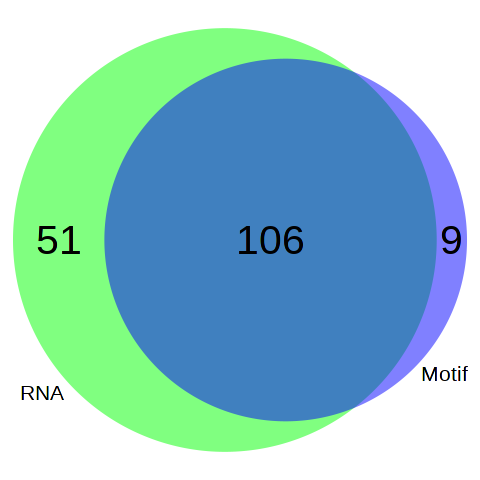

In [120]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff < 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff < 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange < 0)

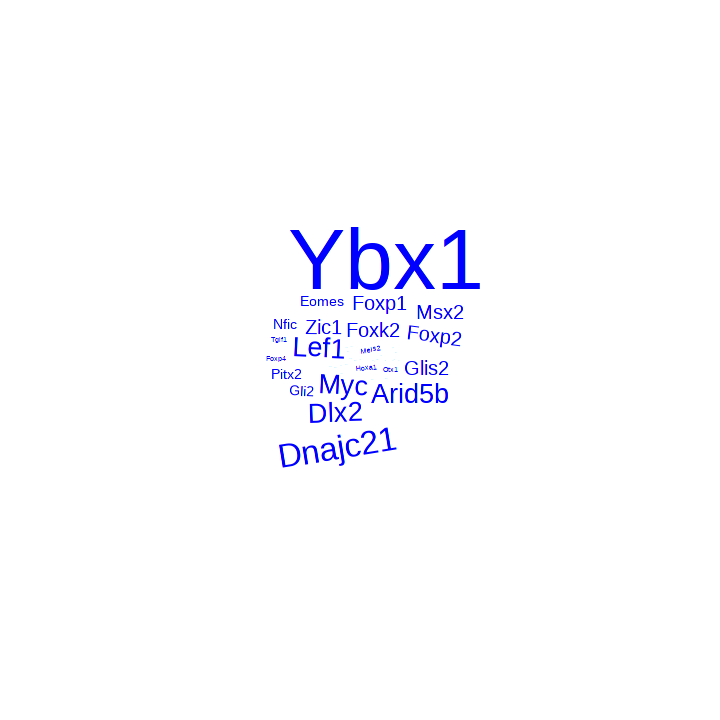

In [121]:
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'blue')

## A set of heatmaps that include commonly up- and down-regulated TFs in both MEF and EB

In [122]:
d_common <- d_merge %>%
  filter(
    (EB_pvalue < 0.05 & MEF_pvalue < 0.05) & 
    ( 
      (MEF_log2FoldChange < 0 & EB_log2FoldChange < 0 & MEF_motif_diff < 0 & EB_motif_diff < 0) |
      (MEF_log2FoldChange > 0 & EB_log2FoldChange > 0 & MEF_motif_diff > 0 & EB_motif_diff > 0)
    )
  ) %>% 
  mutate(symbol = as.character(symbol)) %>%
  arrange(desc(EB_log2FoldChange))
d_common

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fli1,10.8230215,5.097621e-83,0.32156639,8.789963e-03,0.105076522,1.083476e-188,0.150990096,0.000000e+00
Fev,9.3433665,1.459927e-10,0.07294158,3.652266e-07,0.098422554,1.305276e-180,0.144957978,1.459549e-276
Etv2,5.4628796,0.000000e+00,1.11666357,3.666651e-272,0.372727964,0.000000e+00,0.316832862,0.000000e+00
Elk3,3.8932213,7.293291e-176,0.64554017,2.629787e-28,0.005555105,7.374991e-130,0.074024889,4.396243e-76
Myt1l,3.8699385,4.340639e-08,0.01211397,3.800684e-02,0.167792791,8.242979e-276,0.040337461,2.245042e-14
Ar,1.9181900,2.339774e-07,0.30181526,1.305945e-02,0.089243839,1.214839e-14,0.009349840,1.890480e-01
Prdm11,1.4644595,1.509044e-03,0.13141361,4.613107e-02,0.064634981,7.647965e-05,0.025935282,2.163411e-01
Prdm1,1.4226784,1.537160e-09,0.08493177,3.919664e-08,0.003517618,5.583741e-01,0.009577716,5.647055e-03
Xbp1,0.7029344,1.363983e-09,0.69708732,1.384014e-20,0.004497448,5.796198e-11,0.062451987,6.502305e-11


### Bulk RNA-seq in EB

In [123]:
n <- rowData(se_bulk)$refseq_mrna %in% d_common$symbol
cn <- c('EB_NoDox_D25_Etv2', 'EB_Dox_D25_Etv2', 'EB_Dox_D25_Flk1pos_Etv2')
m <- which(colData(se_bulk)$group %in% cn)
m <- m[order(factor(colData(se_bulk)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(se_bulk)$group)
is_dox <- grepl('_Dox_', colData(se_bulk)$group)
X_bulk <- assays(se_bulk[n, m])$normalized_counts %>%
  t() %>%
  scale() %>%
  t()
rownames(X_bulk) <- rowData(se_bulk)$refseq_mrna[n]
X_bulk <- X_bulk[d_common$symbol, ]
X_bulk

Fli1,-1.17367216,-1.3787353,0.47844102,0.495934002,0.7604422,0.8175903
Fev,-1.15816833,-1.4135099,0.65302829,0.577199575,0.6453674,0.6960830
Etv2,-1.32616064,-1.2525618,0.61256255,0.581580263,0.7062182,0.6783614
Elk3,-1.29834803,-1.2831519,0.62938344,0.678193811,0.6492836,0.6246391
Myt1l,-1.06514624,-1.3810735,0.27036077,0.360764705,0.6756317,1.1394627
Ar,-0.90751815,-1.5719330,0.49750138,0.580726726,0.4370081,0.9642149
Prdm11,-0.63693237,-1.0811322,0.62445514,-0.941431362,0.8193571,1.2156838
Prdm1,-1.15982279,-1.3373156,0.62968633,0.176588784,0.9132562,0.7776071
Xbp1,-0.86278005,-1.5637637,0.30627062,0.328076428,0.9337361,0.8584606
Irf9,-0.81861511,-0.2128386,-0.66182833,-0.817977807,1.1455129,1.3657470
Smarcc2,-1.66928329,-0.6708307,0.39171409,0.202811797,0.7221819,1.0234062


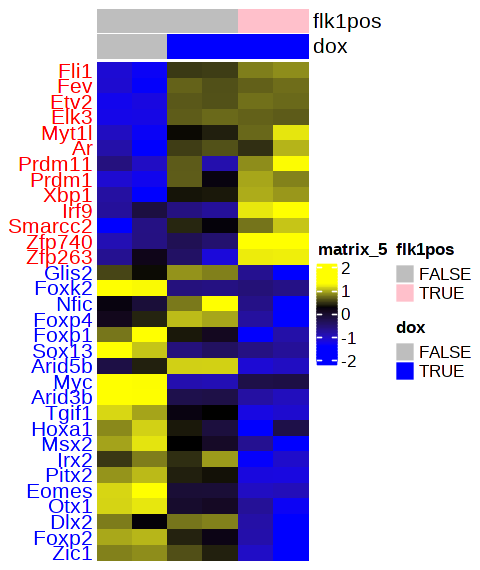

In [124]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
mark_col <- rep('red', nrow(X_bulk))
mark_col[rownames(X_bulk) %in% d_common[d_common$MEF_log2FoldChange < 0, 'symbol']] <- 'blue'
col_fun <- colorRamp2(quantile(X_bulk, c(0.05, 0.5, 0.95)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_bulk,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_side = "left",
  row_names_gp = gpar(col = mark_col)
)

### scRNA-seq in MEF

In [125]:
n <- rowData(se_sc)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7a', 'MEF_Dox_D7b')
m <- which(colData(se_sc)$group %in% cn)
m <- m[order(factor(colData(se_sc)$group[m], cn))]
is_flk1pos <-  colData(se_sc)$group == 'MEF_Dox_D7b'
is_dox <- colData(se_sc)$group != 'MEF_NoDox'
X_sc <- assays(se_sc[n, m])$scaled_counts
rownames(X_sc) <- rowData(se_sc)$name[n]
X_sc <- X_sc[d_common$symbol, ]
X_sc[1:10, 1:10]

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



Fli1,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421
Fev,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135
Etv2,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880
Elk3,1.22651495,-1.05472462,0.50385770,1.24119694,-1.05472462,0.69004071,-0.26701935,-1.05472462,0.54478684,-1.05472462
Myt1l,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622
Ar,-0.55153063,-0.55153063,0.69599303,0.91920213,-0.55153063,-0.55153063,1.79446411,-0.55153063,0.73411920,-0.55153063
Prdm11,-0.17685146,-0.17685146,-0.17685146,2.54272532,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146
Prdm1,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167
Xbp1,-0.76685306,-0.76685306,-0.76685306,-0.76685306,0.79275655,-0.76685306,-0.76685306,-0.76685306,0.35640309,-0.76685306
Irf9,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,1.88682258,-0.27153399,-0.27153399,-0.27153399


`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



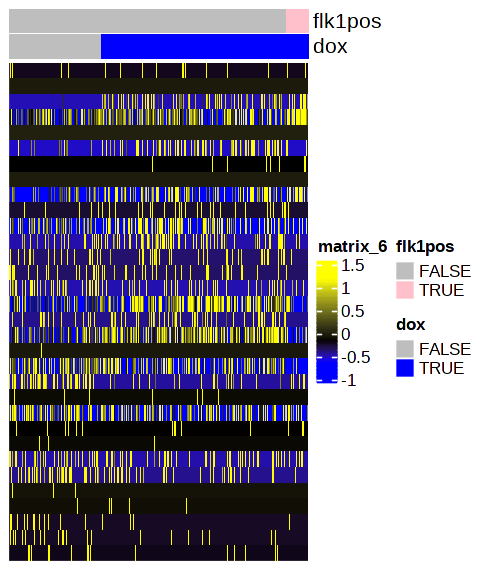

In [126]:
column_annotation <- HeatmapAnnotation(  
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(X_sc, c(0.1, 0.5, 0.9)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_sc,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

### ATAC-seq in EB

In [127]:
n <- rowData(dev_EB)$name %in% d_common$symbol
cn <- c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
m <- which(colData(dev_EB)$group %in% cn)
m <- m[order(factor(colData(dev_EB)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_EB)$group)
is_dox <- grepl('_Dox_', colData(dev_EB)$group)
Y_EB <- assays(dev_EB[n, m])$deviations 
rownames(Y_EB) <- rowData(dev_EB)$name[n]
Y_EB <- Y_EB[d_common$symbol, ]
Y_EB

Fli1,-0.0904461499,-0.088881542,0.0357999076,0.0458949184,0.0517602054,7.089230e-02
Fev,-0.0884484481,-0.085242573,0.0334721880,0.0484308932,0.0477354097,6.848953e-02
Etv2,-0.1911609125,-0.198275069,0.0916350438,0.1070975625,0.1167994010,1.274303e-01
Elk3,-0.0447017001,-0.039432642,0.0122151845,0.0204208745,0.0187528016,4.516264e-02
Myt1l,-0.0247507171,-0.016618436,0.0023171299,0.0043533246,0.0237504292,1.555534e-02
Ar,-0.0054131438,-0.009898207,0.0080257549,0.0061721155,0.0022992721,1.089058e-03
Prdm11,-0.0144909917,-0.011624329,0.0059002621,-0.0023441478,0.0124399490,1.331529e-02
Prdm1,-0.0043657844,-0.003806156,-0.0014594149,-0.0005269293,0.0062549136,4.728578e-03
Xbp1,-0.0251348357,-0.027932194,-0.0107114408,-0.0017313543,0.0327518925,3.908505e-02
Irf9,-0.0175613019,-0.016220168,0.0012139768,-0.0043863070,0.0220028882,1.865420e-02
Smarcc2,-0.0272410590,-0.028348287,0.0094979068,0.0037195186,0.0155213816,3.490455e-02


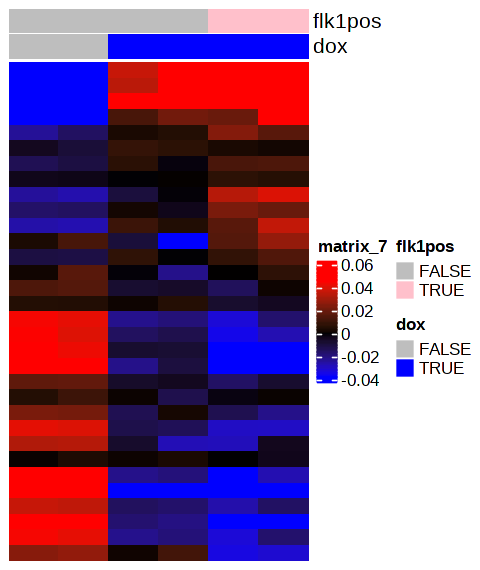

In [128]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_EB, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_EB,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

### ATAC-seq in MEF

In [129]:
n <- rowData(dev_MEF)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
m <- which(colData(dev_MEF)$group %in% cn)
m <- m[order(factor(colData(dev_MEF)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_MEF)$group)
is_dox <- grepl('_Dox_', colData(dev_MEF)$group)
Y_MEF <- assays(dev_MEF[n, m])$deviations 
rownames(Y_MEF) <- rowData(dev_MEF)$name[n]
Y_MEF <- Y_MEF[d_common$symbol, ]
Y_MEF

Fli1,0.002236265,-0.035651950,-0.113773110,-0.028940228,0.0792193707,0.097517989
Fev,0.010159485,-0.034829852,-0.121866064,-0.033665084,0.0729516270,0.099223113
Etv2,-0.140440065,-0.158229130,-0.148064387,-0.046891853,0.2146881544,0.232098578
Elk3,0.058199863,0.012461757,-0.101393773,-0.019300470,0.0349482163,0.046823614
Myt1l,-0.137968799,-0.087799164,0.176573307,0.094969389,0.0625081534,0.047309466
Ar,-0.072437867,-0.045515475,0.077145210,0.033909584,0.0295885855,0.030945750
Prdm11,0.004748622,-0.036532802,-0.009060743,0.028955804,0.0504938774,0.046991905
Prdm1,-0.009099576,-0.005053976,0.015990536,0.012732300,-0.0041658657,-0.002952451
Xbp1,0.044051385,0.018164017,-0.058129572,-0.010496879,0.0245470303,0.046663268
Irf9,0.019049003,-0.005086336,-0.028721618,0.015706741,0.0222166522,0.050009358
Smarcc2,-0.010724123,0.001057421,-0.008252649,0.011775816,0.0038674315,0.008493757


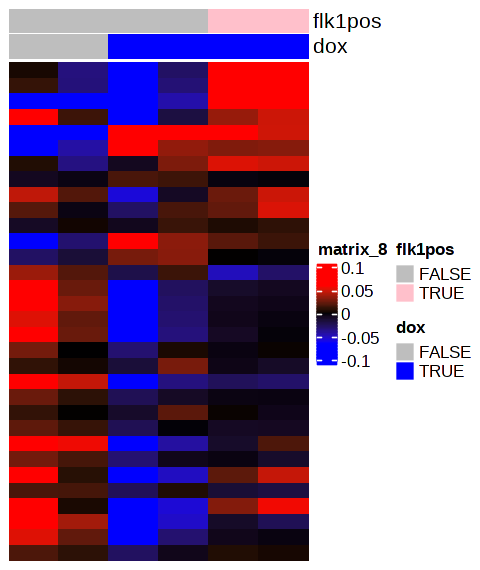

In [130]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_MEF, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_MEF,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

In [131]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggwordcloud_0.5.0                  ggplot2_3.3.3                     
 [3] VennDiagram_1.6.20                 futile.logger_1.4.3               
 [5] DESeq2_1.30.0                      dplyr_1.0.2                       
 [7] plyr

In [132]:
Sys.time() - start_time0

Time difference of 5.281729 mins